In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import os
import time
import pickle
from collections import defaultdict, Counter

# plt 세팅
plt.rc('font', family='Malgun Gothic')  # 한글 폰트
plt.rc('axes', unicode_minus=False)  # 마이너스 기호

In [2]:
# 데이터 로드
def load_data(file_path, region_name):
    df = pd.read_csv(file_path, encoding='utf-8')
    selected_columns = ['상가업소번호', '상호명', '상권업종소분류명']
    df_region = df[selected_columns].copy()
    df_region['지역'] = region_name
    df_clean = df_region.dropna(subset=['상호명', '상권업종소분류명']) # 결측치 제거
    print(f"{region_name} 데이터 크기: {df_clean.shape}")
    return df_clean

In [3]:
# 서울
seoul_file = '.\dataset\서울_202412.csv' 
seoul_df = load_data(seoul_file, '서울')

# 경기
gyeonggi_file = '.\dataset\경기_202412.csv'
gyeonggi_df = load_data(gyeonggi_file, '경기')

서울 데이터 크기: (553535, 4)


C:\Users\hojin\AppData\Local\Temp\ipykernel_29000\1562918823.py:3: DtypeWarning: Columns (35) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, encoding='utf-8')


경기 데이터 크기: (672885, 4)


In [4]:
# seoul_df
gyeonggi_df

,상가업소번호,상호명,상권업종소분류명,지역
0,MA010120220800000037,PENIEL,시계/귀금속 소매업,경기
1,MA010120220800000124,계림찜닭,닭/오리고기 구이/찜,경기
2,MA010120220800000126,한마음부동산,부동산 중개/대리업,경기
3,MA010120220800000165,미사리풀하우스,돼지고기 구이/찜,경기
4,MA010120220800000176,아름다운보석세상,시계/귀금속 소매업,경기
...,...,...,...,...
672880,MA0106202201A2114026,제이에이치케이코퍼레이션,운동용품 소매업,경기
672881,MA0106202201A2277318,김수형공방,가구 소매업,경기
672882,MA0106202201A2166268,도노,기타 의류 소매업,경기
672883,MA0106202201A0284528,킹,백반/한정식,경기


In [5]:
# 데이터 통합
combined_df = pd.concat([seoul_df, gyeonggi_df])
print(combined_df.shape)
print(combined_df['지역'].value_counts())

(1226420, 4)
지역
경기    672885
서울    553535
Name: count, dtype: int64


In [6]:
# 결측치 확인
print("결측치 개수:")
missing_values = combined_df.isnull().sum()
print(missing_values)

결측치 개수:
상가업소번호      0
상호명         0
상권업종소분류명    0
지역          0
dtype: int64


In [7]:
combined_df

,상가업소번호,상호명,상권업종소분류명,지역
0,MA010120220700009628,홈처치스쿨,기타 교육지원 서비스업,서울
1,MA010120220800000033,부동산임대김은숙,카페,서울
2,MA010120220800000036,한국황토건축연구소,부동산 중개/대리업,서울
3,MA010120220800000077,소망공인중개사사무소,부동산 중개/대리업,서울
4,MA010120220800000084,고향집,백반/한정식,서울
...,...,...,...,...
672880,MA0106202201A2114026,제이에이치케이코퍼레이션,운동용품 소매업,경기
672881,MA0106202201A2277318,김수형공방,가구 소매업,경기
672882,MA0106202201A2166268,도노,기타 의류 소매업,경기
672883,MA0106202201A0284528,킹,백반/한정식,경기


In [8]:
# 상호명 정규화
def normalize_store_name(name):
    cleaned = re.sub(r'[^가-힣a-zA-Z0-9]', ' ', name) # 한글, 영문, 숫자만 남기고 나머지는 공백으로 변환
    # 변환 후 연속된 공백 제거
    cleaned = re.sub('  ', ' ', cleaned).strip()
    cleaned = re.sub('   ', ' ', cleaned).strip()
    cleaned = re.sub('    ', ' ', cleaned).strip()
    return cleaned
    # return cleaned.lower()  # 소문자? 대문자? 원본 그대로?
    # return cleaned.upper()

In [9]:
combined_df['상호명_Regulated'] = combined_df['상호명'].apply(normalize_store_name)
combined_df

,상가업소번호,상호명,상권업종소분류명,지역,상호명_Regulated
0,MA010120220700009628,홈처치스쿨,기타 교육지원 서비스업,서울,홈처치스쿨
1,MA010120220800000033,부동산임대김은숙,카페,서울,부동산임대김은숙
2,MA010120220800000036,한국황토건축연구소,부동산 중개/대리업,서울,한국황토건축연구소
3,MA010120220800000077,소망공인중개사사무소,부동산 중개/대리업,서울,소망공인중개사사무소
4,MA010120220800000084,고향집,백반/한정식,서울,고향집
...,...,...,...,...,...
672880,MA0106202201A2114026,제이에이치케이코퍼레이션,운동용품 소매업,경기,제이에이치케이코퍼레이션
672881,MA0106202201A2277318,김수형공방,가구 소매업,경기,김수형공방
672882,MA0106202201A2166268,도노,기타 의류 소매업,경기,도노
672883,MA0106202201A0284528,킹,백반/한정식,경기,킹


In [10]:
# 중복 상호명 확인
df_len = len(combined_df.index)
unique_name_counts = combined_df['상호명_Regulated'].value_counts()
duplicated_names = unique_name_counts[unique_name_counts > 1]

print(f"중복된 상호명 수: {len(duplicated_names)} / {df_len}")
print("고유 상호명 수 :", len(unique_name_counts))
print(f"전체 상호명 중 중복 비율: {len(duplicated_names) / df_len * 100}")

print("\n가장 많이 중복된 상호명")
print(duplicated_names.head(20))

중복된 상호명 수: 113387 / 1226420
고유 상호명 수 : 881212
전체 상호명 중 중복 비율: 9.24536455700331

가장 많이 중복된 상호명
상호명_Regulated
컴퓨터수리         1104
스타벅스          1069
입주청소           752
입시 교과학원        691
김밥천국           419
현대공인중개사사무소     338
업소명없음          336
삼성공인중개사사무소     322
경영 컨설팅업        298
우리공인중개사사무소     274
크린토피아          268
투다리            234
아모레카운셀러        230
전주식당           227
하나공인중개사사무소     222
태후사랑           217
파리바게뜨          210
미래공인중개사사무소     209
아지트            203
행운공인중개사사무소     201
Name: count, dtype: int64


In [11]:
# 중복 상호명의 업종 분포 확인
for name in duplicated_names.index[:5]:
    categories = combined_df[combined_df['상호명_Regulated'] == name]['상권업종소분류명'].value_counts()
    print(f"\n'{name}' 업종 분포:")
    print(categories)


'컴퓨터수리' 업종 분포:
상권업종소분류명
컴퓨터/노트북/프린터 수리업       1051
가전제품 수리업                25
컴퓨터/소프트웨어 소매업           14
그 외 기타 개인/가정용품 수리업       5
사업/무형 재산권 중개업            2
핸드폰 소매업                  2
핸드폰/통신장비 수리업             2
의류/이불 수선업                2
광고 대행업                   1
Name: count, dtype: int64

'스타벅스' 업종 분포:
상권업종소분류명
카페             1067
경영 컨설팅업           1
주방/가정용품 소매업       1
Name: count, dtype: int64

'입주청소' 업종 분포:
상권업종소분류명
건축물 일반 청소업               727
사업시설 유지·관리 서비스업           16
산업설비; 운송장비 및 공공장소 청소업      7
소독; 구충 및 방제 서비스업           1
광고 대행업                     1
Name: count, dtype: int64

'입시 교과학원' 업종 분포:
상권업종소분류명
입시·교과학원    691
Name: count, dtype: int64

'김밥천국' 업종 분포:
상권업종소분류명
김밥/만두/분식    419
Name: count, dtype: int64


In [12]:
def process_duplicate_stores(df, store_col='상호명_Regulated', category_col='상권업종소분류명', verbose=True):
    # 상호명 중복 처리 함수 - 상호명이 중복된 경우 가장 빈도가 높은 업종의 첫번째 컬럼만 남김
    start_time = time.time()
    
    if verbose:
        print(f"원본 데이터: {len(df):,}개 행")
    
    # 고유 상호명을 구해 중복/비중복 여부 구분
    unique_name_counts = df[store_col].value_counts()
    lv_nodup_names = unique_name_counts[unique_name_counts == 1]
    lv_dup_names = unique_name_counts[unique_name_counts > 1]
    
    if verbose:
        print(f"총 고유 상호명 수: {len(unique_name_counts):,}")
        print(f"중복 없는 상호명 수: {len(lv_nodup_names):,}")
        print(f"중복 있는 상호명 수: {len(lv_dup_names):,}")
    
    # 비중복 상호명을 가진 행 리스트에 저장
    selected_rows = df[df[store_col].isin(lv_nodup_names.index)]
    
    if verbose:
        print(f"중복 없는 상호명 처리 완료: {len(selected_rows):,}개 행")
    
    # 중복 상호명 처리
    lv_dup_df = df[df[store_col].isin(lv_dup_names.index)]
    lv_dup_df = lv_dup_df.reset_index(drop=True) #!!인덱스 중복으로 여러 컬럼이 선택되는 문제 해결
    
    if verbose:
        print(f"중복 있는 상호명 데이터: {len(lv_dup_df):,}개 행")
    
    # 업종 빈도 계산
    if verbose:
        print("업종 빈도 계산 시작")
        
    # dict를 활용하여 각 상호명별 업종 빈도 계산
    name_category_counters = defaultdict(Counter)
    for _, row in lv_dup_df.iterrows():
        name = row[store_col]
        category = row[category_col]
        name_category_counters[name][category] += 1
    
    if verbose:
        print(f"업종 빈도 계산 완료: {len(name_category_counters):,}개 상호명")
    
    # 각 상호명별 최빈 업종 저장
    name_top_category = {}  # 각 상호명의 최빈 업종을 저장
    name_first_index = {}   # 각 상호명+최빈업종의 첫 인덱스를 저장
    
    # 각 상호명의 최빈 업종 찾기
    for name, category_counter in name_category_counters.items():
        if len(category_counter) > 0:
            most_common = category_counter.most_common(1)[0]
            top_category = most_common[0]  # 가장 빈도가 높은 업종
            name_top_category[name] = top_category
    
    # 최빈 업종의 첫 번째 인덱스 찾기
    if verbose:
        print("각 상호명별 최빈 업종 탐색")
        
    for idx, row in lv_dup_df.iterrows():
        name = row[store_col]
        category = row[category_col]
        # 상호명에 대한 최빈 업종과 일치하는 경우의 인덱스 저장
        if name in name_top_category and category == name_top_category[name] and name not in name_first_index:
            name_first_index[name] = idx
    
    # 인덱스 value를 모아 리스트로
    selected_indices = list(name_first_index.values())
    
    if verbose:
        print(f"선택된 중복 상호명 인덱스 수: {len(selected_indices):,}")
    
    # 인덱스를 기준으로 데이터프레임 생성
    selected_rows_dup = lv_dup_df.loc[selected_indices]
    
    if verbose:
        print(f"중복 있는 상호명 처리 완료: {len(selected_rows_dup):,}개 행 선택됨")
    
    # 중복/비중복 df concat
    lv_final_df = pd.DataFrame(columns=df.columns)
    lv_final_df = pd.concat([lv_final_df, selected_rows, selected_rows_dup], ignore_index=True)
    
    if verbose:
        print(f"최종 데이터 크기: {len(lv_final_df):,}개 행")
        print(f"제거된 중복 데이터: {len(df) - len(lv_final_df):,}개 행")
        print(f"총 소요 시간: {time.time() - start_time:.2f}초")
    
    return lv_final_df

In [13]:
# 중복 상호명 처리
processed_df = process_duplicate_stores(combined_df, verbose=True)

원본 데이터: 1,226,420개 행
총 고유 상호명 수: 881,212
중복 없는 상호명 수: 767,825
중복 있는 상호명 수: 113,387
중복 없는 상호명 처리 완료: 767,825개 행
중복 있는 상호명 데이터: 458,595개 행
업종 빈도 계산 시작
업종 빈도 계산 완료: 113,387개 상호명
각 상호명별 최빈 업종 탐색
선택된 중복 상호명 인덱스 수: 113,387
중복 있는 상호명 처리 완료: 113,387개 행 선택됨
최종 데이터 크기: 881,212개 행
제거된 중복 데이터: 345,208개 행
총 소요 시간: 16.69초


In [14]:
unique_name_counts = processed_df['상호명_Regulated'].value_counts()
lv_nodup_names = unique_name_counts[unique_name_counts == 1]
lv_dup_names = unique_name_counts[unique_name_counts > 1]

In [15]:
len(lv_nodup_names)

881212

# 여기서부터 다시 작성

In [16]:
# 특정 상호명으로 처리 결과 확인
def check_processing_results(original_df, processed_df, sample_names):
    """특정 상호명들에 대한 처리 결과를 확인합니다."""
    for name in sample_names:
        print(f"\n'{name}' 처리 결과:")
        
        # 원본 데이터에서 해당 상호명 검색
        original_records = original_df[original_df['상호명_Regulated'] == name.lower()]
        print(f"원본 데이터 레코드 수: {len(original_records)}")
        
        if not original_records.empty:
            print("원본 업종 분포:")
            print(original_records['상권업종소분류명'].value_counts())
        
        # 처리된 데이터에서 해당 상호명 검색
        processed_records = processed_df[processed_df['상호명_Regulated'] == name.lower()]
        print(f"처리 후 레코드 수: {len(processed_records)}")
        
        if not processed_records.empty:
            print("처리 후 업종 분포:")
            print(processed_records['상권업종소분류명'].value_counts())
            print("\n처리된 레코드:")
            print(processed_records[['상호명', '상호명_Regulated', '상권업종소분류명']])

# 확인할 상호명 샘플 (데이터에 있는 상호명으로 변경 필요)
sample_names = duplicated_names.index[:5].tolist()  # 상위 5개 중복 상호명

# 처리 결과 확인
check_processing_results(combined_df, processed_df, sample_names)



'컴퓨터수리' 처리 결과:
원본 데이터 레코드 수: 1104
원본 업종 분포:
상권업종소분류명
컴퓨터/노트북/프린터 수리업       1051
가전제품 수리업                25
컴퓨터/소프트웨어 소매업           14
그 외 기타 개인/가정용품 수리업       5
사업/무형 재산권 중개업            2
핸드폰 소매업                  2
핸드폰/통신장비 수리업             2
의류/이불 수선업                2
광고 대행업                   1
Name: count, dtype: int64
처리 후 레코드 수: 1
처리 후 업종 분포:
상권업종소분류명
컴퓨터/노트북/프린터 수리업    1
Name: count, dtype: int64

처리된 레코드:
          상호명 상호명_Regulated         상권업종소분류명
769088  컴퓨터수리         컴퓨터수리  컴퓨터/노트북/프린터 수리업

'스타벅스' 처리 결과:
원본 데이터 레코드 수: 1069
원본 업종 분포:
상권업종소분류명
카페             1067
경영 컨설팅업           1
주방/가정용품 소매업       1
Name: count, dtype: int64
처리 후 레코드 수: 1
처리 후 업종 분포:
상권업종소분류명
카페    1
Name: count, dtype: int64

처리된 레코드:
         상호명 상호명_Regulated 상권업종소분류명
842582  스타벅스          스타벅스       카페

'입주청소' 처리 결과:
원본 데이터 레코드 수: 752
원본 업종 분포:
상권업종소분류명
건축물 일반 청소업               727
사업시설 유지·관리 서비스업           16
산업설비; 운송장비 및 공공장소 청소업      7
소독; 구충 및 방제 서비스업           1
광고 대행업                     1
Name: co

In [17]:
# 좀 더 상세한 정제를 위한 함수 (추가 패턴 처리)
def clean_category_names_advanced(df):
    """
    상권업종소분류명을 가계부에 더 적합한 형태로 변환 (상세 버전):
    1. '*소매업'에서 '소매업' 제거
    2. '*수리업', '*수선업', '*서비스업', '*청소업'에서 '업' 제거
    3. '기타 *', '그 외 *' 등의 패턴 정리
    4. 특수문자 처리
    """
    print("소분류명 상세 정제 시작...")
    start_time = time.time()
    
    # 원본 데이터 복사
    df_clean = df.copy()
    
    # 변환 전 고유 소분류명 수 확인
    original_categories = df_clean['상권업종소분류명'].unique()
    print(f"변환 전 고유 소분류명 수: {len(original_categories)}")
    
    # 패턴 사전 정의
    remove_suffix_patterns = {
        r'소매업$': '',           # '소매업'으로 끝나는 경우 제거
        r'(수리|수선|서비스|청소|대리|중개|매매|판매|컨설팅|대행)업$': r'\1',  # '수리업' -> '수리'로 변환
    }
    
    # 기타 패턴 처리
    other_patterns = {
        r'^그 외 기타 (.+)$': r'\1(기타)',  # '그 외 기타 소매업' -> '소매(기타)'
        # r'^기타 (.+)$': r'\1(기타)',        # '기타 소매업' -> '소매(기타)' # 넣으니까 정렬 꼬임 나중에 필요하면 다시 활성화
    }
    
    # 변환 함수
    def transform_category_advanced(category):
        # 소문자 변환 없이 원본 그대로 사용
        transformed = category
        
        # 접미사 패턴 처리
        for pattern, replacement in remove_suffix_patterns.items():
            transformed = re.sub(pattern, replacement, transformed)
        
        # 기타 패턴 처리
        for pattern, replacement in other_patterns.items():
            transformed = re.sub(pattern, replacement, transformed)
        
        return transformed.strip()  # 앞뒤 공백 제거
    
    # 변환 적용
    df_clean['업종소분류_Regulated'] = df_clean['상권업종소분류명'].apply(transform_category_advanced)
    
    # 변환 후 고유 소분류명 수 확인
    cleaned_categories = df_clean['업종소분류_Regulated'].unique()
    print(f"변환 후 고유 소분류명 수: {len(cleaned_categories)}")
    
    # 변환 예시 출력
    print("\n변환 예시 (변경된 항목만):")
    examples = []
    for orig, cleaned in zip(original_categories, 
                            [transform_category_advanced(cat) for cat in original_categories]):
        if orig != cleaned:
            examples.append((orig, cleaned))
    
    # 최대 30개까지만 출력
    for orig, cleaned in examples[:30]:
        print(f"  '{orig}' -> '{cleaned}'")
    
    # 변경 안 된 예시도 몇 개 출력
    unchanged = [(orig, orig) for orig in original_categories if orig == transform_category_advanced(orig)]
    if unchanged:
        print("\n변경되지 않은 항목 예시 (5개):")
        for orig, cleaned in unchanged[:5]:
            print(f"  '{orig}' (변경 없음)")
    
    print(f"\n소분류명 정제 완료. 소요 시간: {time.time() - start_time:.2f}초")
    
    return df_clean

In [18]:
proc_shop_cat_df = clean_category_names_advanced(processed_df)

소분류명 상세 정제 시작...
변환 전 고유 소분류명 수: 247
변환 후 고유 소분류명 수: 247

변환 예시 (변경된 항목만):
  '기타 교육지원 서비스업' -> '기타 교육지원 서비스'
  '부동산 중개/대리업' -> '부동산 중개/대리'
  '건강보조식품 소매업' -> '건강보조식품'
  '악기 소매업' -> '악기'
  '시계/귀금속/악기 수리업' -> '시계/귀금속/악기 수리'
  '의료기기 소매업' -> '의료기기'
  '시계/귀금속 소매업' -> '시계/귀금속'
  '가전제품 소매업' -> '가전제품'
  '그 외 기타 간이 음식점' -> '간이 음식점(기타)'
  '예술품 소매업' -> '예술품'
  '복권 발행/판매업' -> '복권 발행/판매'
  '그 외 기타 개인/가정용품 수리업' -> '개인/가정용품 수리(기타)'
  '가전제품 수리업' -> '가전제품 수리'
  '그 외 기타 상품 전문 소매업' -> '상품 전문 (기타)'
  '중고 상품 소매업' -> '중고 상품'
  '기타 의류 소매업' -> '기타 의류'
  '컴퓨터/노트북/프린터 수리업' -> '컴퓨터/노트북/프린터 수리'
  '사업/무형 재산권 중개업' -> '사업/무형 재산권 중개'
  '문구/회화용품 소매업' -> '문구/회화용품'
  '담배/전자담배 소매업' -> '담배/전자담배'
  '경영 컨설팅업' -> '경영 컨설팅'
  '건축 설계 및 관련 서비스업' -> '건축 설계 및 관련 서비스'
  '가죽/가방/신발 수선업' -> '가죽/가방/신발 수선'
  '주방/가정용품 소매업' -> '주방/가정용품'
  '자전거 소매업' -> '자전거'
  '철물/공구 소매업' -> '철물/공구'
  '광고 대행업' -> '광고 대행'
  '화장품 소매업' -> '화장품'
  '건축물 일반 청소업' -> '건축물 일반 청소'
  '신발 소매업' -> '신발'

변경되지 않은 항목 예시 (5개):
  '카페' (변경 없음)
  '명함/간판/광고물 제작' (변경 없음)
  '미용실'

In [19]:
def encode_categories(df, category_col='상권업종소분류명', class_col='클래스', save_mapping=True, mapping_file='./processed_data/category_mapping.pkl'):
    """
    업종소분류를 클래스 인코딩하는 함수
    
    Parameters:
    -----------
    df : pandas.DataFrame
        처리할 데이터프레임
    category_col : str
        업종소분류가 저장된 컬럼명
    class_col : str
        생성할 클래스 컬럼명
    save_mapping : bool
        매핑 정보를 파일로 저장할지 여부
    mapping_file : str
        매핑 정보를 저장할 파일명
        
    Returns:
    --------
    pandas.DataFrame
        클래스 인코딩이 추가된 데이터프레임
    dict
        업종소분류-클래스 매핑 딕셔너리
    """
    # 고유 업종 추출 및 정렬 (정렬하면 일관성 유지 가능)
    unique_categories = sorted(df[category_col].unique())
    
    # 각 업종에 C1, C2, ... 형태의 클래스 할당
    category_to_class = {category: f'{i}' for i, category in enumerate(unique_categories)}
    
    # 클래스 컬럼 추가
    df[class_col] = df[category_col].map(category_to_class)
    
    # 결과 확인
    print(f"총 {len(unique_categories):,}개의 고유 업종 클래스로 인코딩 완료")
    print(f"첫 10개 업종-클래스 매핑:")
    for i, (category, class_id) in enumerate(list(category_to_class.items())[:10]):
        print(f"{i+1}. {category} -> {class_id}")
    
    # 매핑 정보 저장
    if save_mapping:
        with open(mapping_file, 'wb') as f:
            pickle.dump(category_to_class, f)
        print(f"매핑 정보를 '{mapping_file}'에 저장했습니다.")
    
    return df, category_to_class

In [20]:
_, encode_df = encode_categories(proc_shop_cat_df, '업종소분류_Regulated')

총 247개의 고유 업종 클래스로 인코딩 완료
첫 10개 업종-클래스 매핑:
1. PC방 -> 0
2. 가구 -> 1
3. 가발 -> 2
4. 가방 -> 3
5. 가스 충전소 -> 4
6. 가전제품 -> 5
7. 가전제품 수리 -> 6
8. 가정용 연료 -> 7
9. 가죽/가방/신발 수선 -> 8
10. 가축 사료 -> 9
매핑 정보를 './processed_data/category_mapping.pkl'에 저장했습니다.


In [21]:
encode_df

{'PC방': '0',
 '가구': '1',
 '가발': '2',
 '가방': '3',
 '가스 충전소': '4',
 '가전제품': '5',
 '가전제품 수리': '6',
 '가정용 연료': '7',
 '가죽/가방/신발 수선': '8',
 '가축 사료': '9',
 '간이 음식점(기타)': '10',
 '개인/가정용품 수리(기타)': '11',
 '건강보조식품': '12',
 '건물 및 토목 엔지니어링 서비스': '13',
 '건설/건축자재': '14',
 '건설기계/장비 대여업': '15',
 '건어물/젓갈': '16',
 '건축 설계 및 관련 서비스': '17',
 '건축물 일반 청소': '18',
 '결혼 상담 서비스': '19',
 '경양식': '20',
 '경영 컨설팅': '21',
 '고용 알선업': '22',
 '곡물/곡분': '23',
 '골프 연습장': '24',
 '곱창 전골/구이': '25',
 '공인노무사': '26',
 '공인회계사': '27',
 '광고 대행': '28',
 '광고 매체 판매': '29',
 '광고물 설계/제작업': '30',
 '교육기관(기타)': '31',
 '교육컨설팅': '32',
 '구내식당': '33',
 '국/탕/찌개류': '34',
 '국수/칼국수': '35',
 '기념품점': '36',
 '기숙사/고시원': '37',
 '기타 개인/가정용품 대여업': '38',
 '기타 건설/건축자재': '39',
 '기타 광고 관련 서비스': '40',
 '기타 교육지원 서비스': '41',
 '기타 기술/직업 훈련학원': '42',
 '기타 동남아식 전문': '43',
 '기타 법무관련 서비스': '44',
 '기타 사무 지원 서비스': '45',
 '기타 산업용 기계/장비 대여업': '46',
 '기타 서양식 음식점': '47',
 '기타 스포츠시설 운영업': '48',
 '기타 엔지니어링 서비스': '49',
 '기타 여행 보조/예약 서비스': '50',
 '기타 예술/스포츠 교육기관': '51',
 '기타 오락

In [22]:
# 지역별 분포 확인
region_counts = proc_shop_cat_df['지역'].value_counts()
print("\n지역별 데이터 분포:")
print(region_counts)

# 업종 분포 확인
category_counts = proc_shop_cat_df['상권업종소분류명'].value_counts()
print(f"\n총 업종 수: {len(category_counts)}")
print("\n상위 20개 업종:")
print(category_counts.head(20))


지역별 데이터 분포:
지역
경기    450811
서울    430401
Name: count, dtype: int64

총 업종 수: 247

상위 20개 업종:
상권업종소분류명
백반/한정식             39614
카페                 38250
입시·교과학원            32559
경영 컨설팅업            31890
부동산 중개/대리업         31099
미용실                29265
편의점                20842
광고 대행업             17559
기타 의류 소매업          15454
돼지고기 구이/찜          15442
요리 주점              15264
슈퍼마켓               14654
김밥/만두/분식           12047
피부 관리실             11719
빵/도넛               10611
자동차 정비소            10514
건축 설계 및 관련 서비스업     9466
요가/필라테스 학원          9091
사진촬영업               9081
치킨                  8832
Name: count, dtype: int64


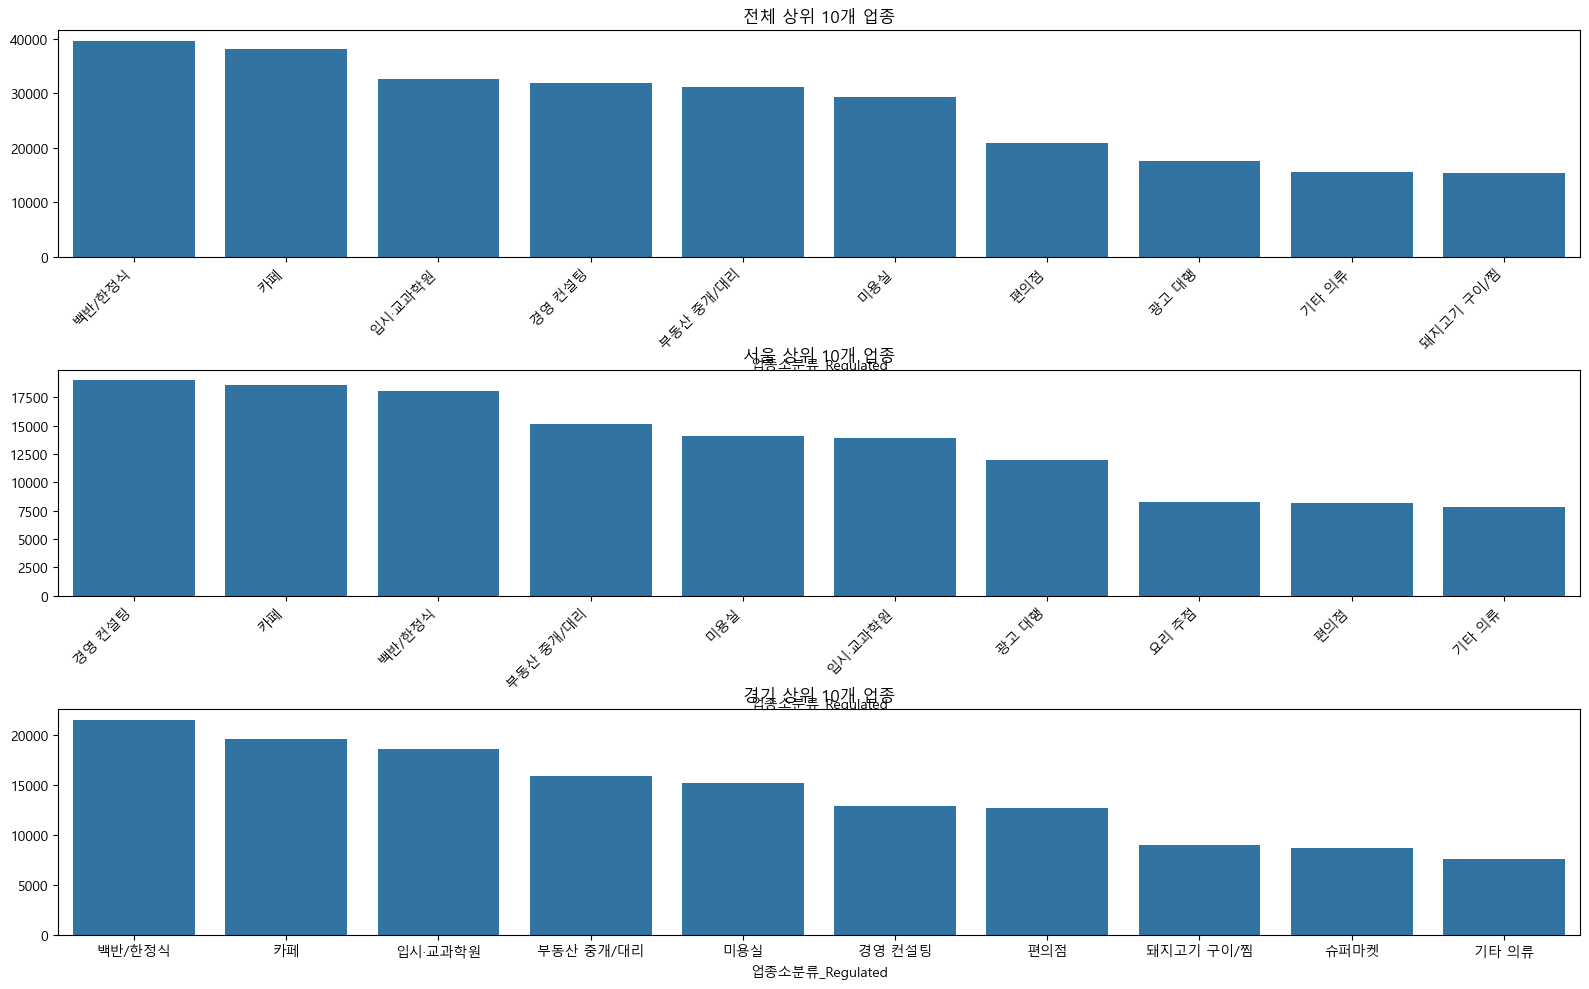

In [23]:
# 지역별 상위 업종 비교
plt.figure(figsize=(16, 10))

# 전체
plt.subplot(3, 1, 1)
seoul_categories = proc_shop_cat_df['업종소분류_Regulated'].value_counts().head(10)
sns.barplot(x=seoul_categories.index, y=seoul_categories.values)
plt.title('전체 상위 10개 업종')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# 서울 상위 10개
plt.subplot(3, 1, 2)
seoul_categories = proc_shop_cat_df[proc_shop_cat_df['지역'] == '서울']['업종소분류_Regulated'].value_counts().head(10)
sns.barplot(x=seoul_categories.index, y=seoul_categories.values)
plt.title('서울 상위 10개 업종')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()

# 경기 상위 10개
plt.subplot(3, 1, 3)
gyeonggi_categories = proc_shop_cat_df[proc_shop_cat_df['지역'] == '경기']['업종소분류_Regulated'].value_counts().head(10)
sns.barplot(x=gyeonggi_categories.index, y=gyeonggi_categories.values)
plt.title('경기 상위 10개 업종')
plt.xticks()
# plt.xticks(rotation=45, ha='right')
plt.tight_layout()

plt.subplots_adjust(hspace=0.5)
plt.show()

In [24]:
# 최종 데이터셋 준비
final_df = proc_shop_cat_df[['상가업소번호', '지역', '상호명_Regulated', '업종소분류_Regulated', '클래스']]

# 데이터 저장 디렉토리 생성
output_dir = './processed_data'
os.makedirs(output_dir, exist_ok=True)

# CSV 파일로 저장
output_path = f"{output_dir}/seoul_gyeonggi_combined_data.csv"
final_df.to_csv(output_path, index=False, encoding='utf-8')

print(f"\n통합 데이터가 저장되었습니다: {output_path}")
print(f"최종 데이터 크기: {final_df.shape}")


통합 데이터가 저장되었습니다: ./processed_data/seoul_gyeonggi_combined_data.csv
최종 데이터 크기: (881212, 5)


In [25]:
# 지역별 데이터도 따로 저장
for region in final_df['지역'].unique():
    region_df = final_df[final_df['지역'] == region]
    region_output = f"{output_dir}/{region}_processed_data.csv"
    region_df.to_csv(region_output, index=False, encoding='utf-8')
    print(f"{region} 데이터 저장 완료: {region_output} (크기: {region_df.shape})")

서울 데이터 저장 완료: ./processed_data/서울_processed_data.csv (크기: (430401, 5))
경기 데이터 저장 완료: ./processed_data/경기_processed_data.csv (크기: (450811, 5))


In [26]:
# 전체 데이터 요약
print("\n=== 데이터 통합 및 처리 요약 ===")
print(f"원본 서울 데이터 크기: {seoul_df.shape}")
print(f"원본 경기 데이터 크기: {gyeonggi_df.shape}")
print(f"통합 데이터 크기: {combined_df.shape}")
print(f"중복 처리 후 데이터 크기: {processed_df.shape}")
print(f"제거된 중복 레코드 수: {len(combined_df) - len(processed_df)}")
print(f"데이터 감소율: {(len(combined_df) - len(processed_df)) / len(combined_df):.2%}")
print(f"고유 상호명 수: {final_df['상호명_Regulated'].nunique():,}개")
print(f"고유 업종 수: {final_df['업종소분류_Regulated'].nunique():,}개")

# 지역별 통계
print("\n지역별 통계:")
for region in final_df['지역'].unique():
    region_df = final_df[final_df['지역'] == region]
    print(f"- {region} 데이터: {len(region_df):,}개 ({len(region_df)/len(processed_df):.1%})")
    print(f"  고유 상호명 수: {region_df['상호명_Regulated'].nunique():,}개")
    print(f"  고유 업종 수: {region_df['업종소분류_Regulated'].nunique():,}개")
    print(f"  가장 많은 업종: {region_df['업종소분류_Regulated'].value_counts().index[0]}")


=== 데이터 통합 및 처리 요약 ===
원본 서울 데이터 크기: (553535, 4)
원본 경기 데이터 크기: (672885, 4)
통합 데이터 크기: (1226420, 5)
중복 처리 후 데이터 크기: (881212, 5)
제거된 중복 레코드 수: 345208
데이터 감소율: 28.15%
고유 상호명 수: 881,212개
고유 업종 수: 247개

지역별 통계:
- 서울 데이터: 430,401개 (48.8%)
  고유 상호명 수: 430,401개
  고유 업종 수: 247개
  가장 많은 업종: 경영 컨설팅
- 경기 데이터: 450,811개 (51.2%)
  고유 상호명 수: 450,811개
  고유 업종 수: 247개
  가장 많은 업종: 백반/한정식


C:\Users\hojin\AppData\Local\Temp\ipykernel_29000\749918710.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['상호명_Regulated_길이'] = final_df['상호명_Regulated'].apply(len)



상호명 길이 통계:
       상호명_Regulated_길이
count     881212.000000
mean           6.672123
std            3.052121
min            0.000000
25%            4.000000
50%            6.000000
75%            8.000000
max           51.000000


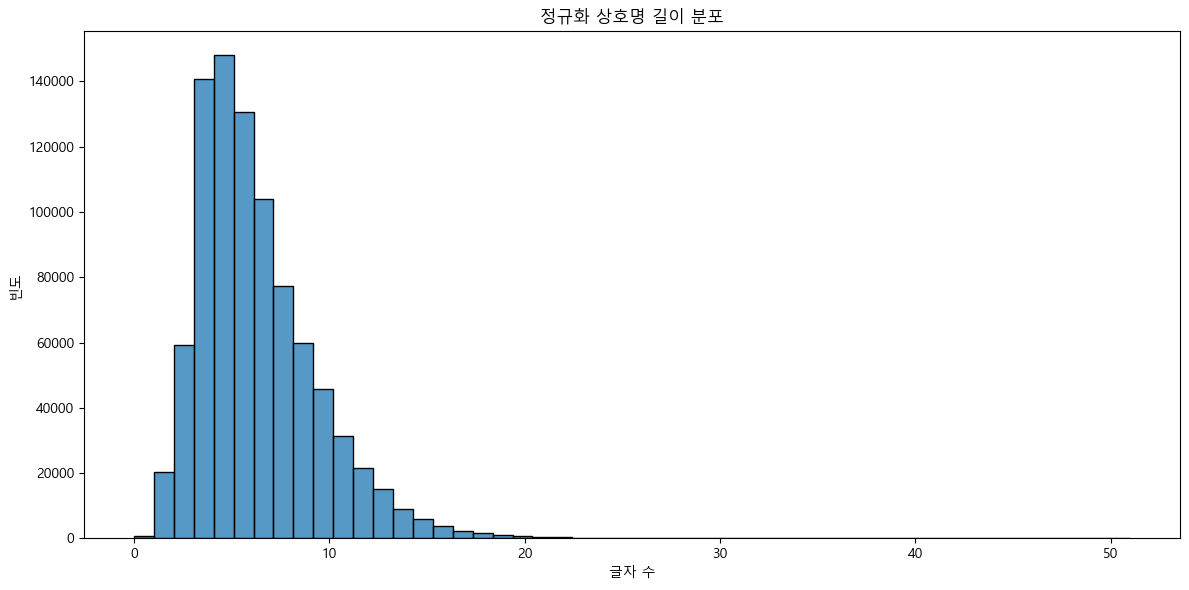

In [27]:
# 상호명 길이 분포
final_df['상호명_Regulated_길이'] = final_df['상호명_Regulated'].apply(len)

# 길이 통계
print("\n상호명 길이 통계:")
print(final_df[['상호명_Regulated_길이']].describe())

# 상호명 길이 분포 시각화
plt.figure(figsize=(12, 6))
sns.histplot(final_df['상호명_Regulated_길이'], bins=50)
plt.title('정규화 상호명 길이 분포')
plt.xlabel('글자 수')
plt.ylabel('빈도')

plt.tight_layout()
plt.show()

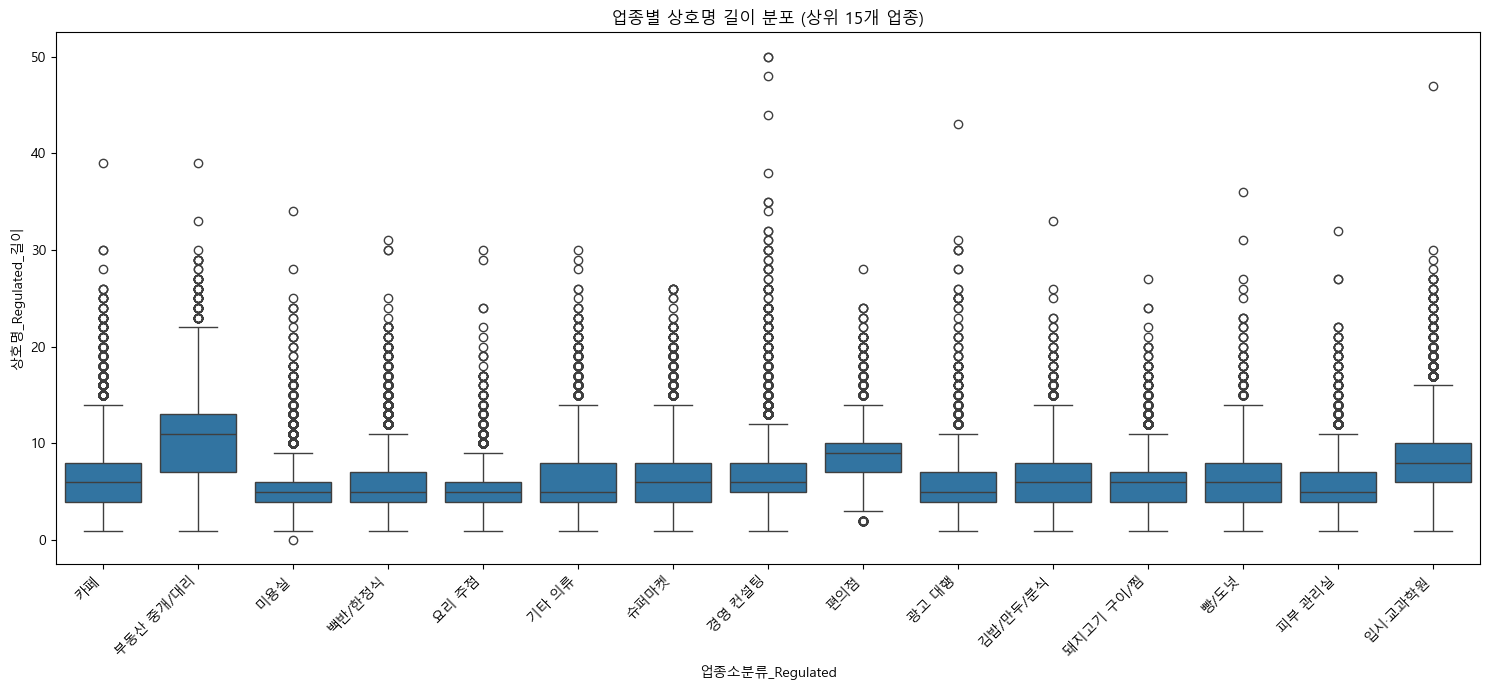

백반/한정식: 39,614개
카페: 38,250개
입시·교과학원: 32,559개
경영 컨설팅: 31,890개
부동산 중개/대리: 31,099개
미용실: 29,265개
편의점: 20,842개
광고 대행: 17,559개
기타 의류: 15,454개
돼지고기 구이/찜: 15,442개
요리 주점: 15,264개
슈퍼마켓: 14,654개
김밥/만두/분식: 12,047개
피부 관리실: 11,719개
빵/도넛: 10,611개


In [28]:
# 업종별 상호명 길이 분석 (상위 15개 업종)
category_counts = final_df['업종소분류_Regulated'].value_counts()
top_categories = category_counts.head(15).index.tolist()
plt.figure(figsize=(15, 7))  # 그래프 크기 조금 더 늘림

# 데이터 필터링
filtered_data = final_df[final_df['업종소분류_Regulated'].isin(top_categories)]

# boxplot 생성 
sns.boxplot(x='업종소분류_Regulated', y='상호명_Regulated_길이', 
           data=filtered_data)

plt.title('업종별 상호명 길이 분포 (상위 15개 업종)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# 업종별 데이터 개수 확인 (확인용)
for category in top_categories:
    count = len(filtered_data[filtered_data['업종소분류_Regulated'] == category])
    print(f"{category}: {count:,}개")